In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
import rubin_sim.photUtils as photUtils
import rubin_sim.site_models as site_models
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_data_dir, get_baseline
import syseng_throughputs as st

## m5 and Cm Evaluation ##

Rubin Observatory has minimum and design requirements on single-visit point source magnitude limits (`m5`, limiting magnitudes, m5 depth, etc.). These are encoded in the LSST Science Requirements Document (SRD), but were formulated under initial assumptions of observing conditions and potential throughputs. As we progress towards operations, we have more information on the as-built system (throughputs, readnoise, etc) and have been gathering more information on site conditions (seeing and skybrightness). Our model of the expected single-visit limiting magnitudes can thus be improved. 

One complicating factor in looking at the resulting expected m5 depths is to separate the effects of the hardware being built from the effects of improving our understanding of the observing conditions. To aid with this, we include evaluations of `Cm`, which encodes the throughput of the system at a fixed set of skybrightness, seeing, exposure time, and airmass. 

The expected depths can also vary depending on survey strategy. To separate the observatory from the survey cadence, we also evaluate the expected depths in a limited set of conditions; where the airmass is minimum (at zenith, `X=1`), in dark-sky (new moon) conditions, and at the median predicted seeing. This matches the observing conditions defined in the SRD.

In [2]:
# To compare against SRD and Overview paper values, we will use the Cm value, potentially as well as m5
# The benefit of Cm is that it translates whatever is being achieved in m5 against a fixed set of fiducial
# assumptions -- assuming that the seeing is 0.7 and the skybrightness is 21. 
def m5_to_Cm(m5, skyMag, fwhmEff, kAtm, expTimeTotal=30, X=1.0):
    Cm = (m5 
          - 0.5 * (skyMag - 21) 
          - 2.5 * np.log10(0.7/fwhmEff) 
          - 1.25 * np.log10(expTimeTotal/30.0) 
          + kAtm * (X-1))
    return Cm

SRD only

In [3]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')

# Fiducial M5 values from the SRD
m5_fid = {'u': 23.9, 'g': 25.0, 'r': 24.7, 'i': 24.0, 'z': 23.3, 'y': 22.1}
m5_min = {'u': 23.4, 'g': 24.6, 'r': 24.3, 'i': 23.6, 'z': 22.9, 'y': 21.7}

In [4]:
# Calculate Cm values corresponding to these SRD m5 values
# For the SRD values, these will be calculated using the seeing and sky values from 
# the initial version of table 2 from the LSE-40 
# http://faculty.washington.edu/ivezic/Teaching/Astr511/LSST_SNRdoc.pdf
# (using y4 for y band)

kAtm_srd = {'u': 0.451,
           'g': 0.163,
           'r': 0.087,
           'i': 0.065,
           'z': 0.043,
           'y': 0.138}

seeing_srd = {'u': 0.77,
             'g': 0.73,
             'r': 0.70,
             'i': 0.67,
             'z': 0.65,
             'y': 0.63}

skymag_srd = {'u': 22.92,
             'g': 22.27,
             'r': 21.20,
             'i': 20.47,
             'z': 19.59,
             'y': 18.63}

m5 = {}
m5['srd'] = m5_fid

Cm = {}
Cm['srd'] = {}

for f in filterlist:
    Cm['srd'][f] = m5_to_Cm(m5['srd'][f], skymag_srd[f], seeing_srd[f], kAtm_srd[f], X=1.0)
pd.DataFrame([m5['srd'], Cm['srd']], index=['m5 srd', 'Cm srd'])

,u,g,r,i,z,y
m5 srd,23.900000,25.000000,24.7,24.000000,23.300000,22.100000
Cm srd,23.043482,24.410562,24.6,24.217442,23.924538,23.170606


Current design, with fiducial seeing and skybrightness (fiducial values are not the values consistent with the most up to date site models used in the cadence simulations, but do match values which have been previously used for agency evaluation and thus provide consistency over time). 

In [5]:
# Pull in design values, related to current SRD-style calculations

# Set up PhotometricParameters object - which stores readnoise, etc
readnoise = 8.8 # e-/read
darkcurrent = 0.2 # e-/s
photParameters_15 = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1, 
                                                     readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
photParameters_30 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1,
                                                   readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
# Make it easier to retrieve the appropriate version per-bandpass
photParams = {}
photParams['u'] = photParameters_30
for f in ('g', 'r', 'i', 'z', 'y'):
    photParams[f] = photParameters_15

# Fiducial seeing values (this is what is used in the SRD)
# These fiducial seeing values correspond to the "original" 500nm zenith atmospheric seeing expected at site
# equivalent to fwhm_500 = 0.62" (using our current seeing model) - see next cell
lsstDefaults = photUtils.LSSTdefaults()
fid_fwhmEff = {}
for f in filterlist:
    fid_fwhmEff[f] = lsstDefaults.FWHMeff(f)

In [6]:
# Validate 'equivalent fid_fwhm_500' using our current seeing model
fid_fwhm_500 = 0.62
seeing_model = site_models.SeeingModel()
seeing = seeing_model(fid_fwhm_500, 1.0)
pd.DataFrame([seeing['fwhmEff'], [fid_fwhmEff[f] for f in filterlist]], 
             index=['delivered fwhm', 'fiducial fwhm'], columns=filterlist)

,u,g,r,i,z,y
delivered fwhm,0.928137,0.874696,0.827759,0.796348,0.774526,0.757899
fiducial fwhm,0.920000,0.870000,0.830000,0.800000,0.780000,0.760000


In [7]:
# (and I'm curious .. the srd_seeing values correspond to what atmospheric fwhm500 value?)
test_fwhm_500 = 0.475
a1 = seeing_model(test_fwhm_500, 1.0)['fwhmEff']
a2 = np.array(list(seeing_srd.values()))
print(a1)
print(a2)
print(a1-a2)
# Note that this fiducial FWHM_500 has evolved considerably

[0.77067489 0.73306874 0.70034858 0.67863405 0.66364453 0.65227941]
[0.77 0.73 0.7  0.67 0.65 0.63]
[0.00067489 0.00306874 0.00034858 0.00863405 0.01364453 0.02227941]


In [8]:
# Set up to read components (from syseng_throughputs repository)
throughputDirs = st.setDefaultDirs()

In [9]:
# Read dark sky and X=1 atmosphere (default is to use X=1.2 atmosphere otherwise)
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(st.findRootDir(), 'siteProperties', 'darksky.dat'))
atmosphere = st.readAtmosphere(throughputDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

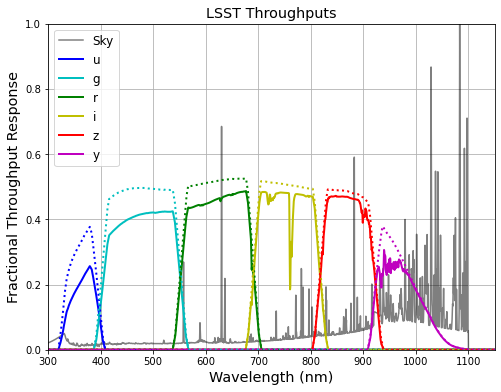

In [10]:
# Read components, directly from syseng_throughputs repository
throughputDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(throughputDirs, atmosphereOverride=atmosphere)

# Read dark sky
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(st.findRootDir(), 'siteProperties', 'darksky.dat'))

plt.figure(figsize=(8,6))
plt.plot(darksky.wavelen, darksky.flambda/darksky.flambda.max(), 'k-', alpha=0.5, label='Sky')
st.plotBandpasses(system, 'LSST Throughputs', newfig=False, addlegend=True)
plt.legend(loc='upper left', fancybox=True, fontsize='large')
st.plotBandpasses(hardware, newfig=False, linestyle=':', addlegend=False)

In [11]:
# Calculate extinction coefficients to translate to Cm - 
# these will be the same for every use of the throughput curves
Tb = {}
Sb = {}
kAtm = {}
skyMag = {}
for f in filterlist:
    dwavelen = np.unique(np.diff(system[f].wavelen)).mean()
    Tb[f] = np.sum(system[f].sb / system[f].wavelen) * dwavelen
    Sb[f] = np.sum(hardware[f].sb / hardware[f].wavelen) * dwavelen
    kAtm[f] = -2.5 * np.log10(Tb[f] / Sb[f])
    # Can calculate skyMag here too as it is atmosphere and seeing independent 
    skyMag[f] = darksky.calcMag(hardware[f])
pd.DataFrame([kAtm_srd, kAtm, skymag_srd, skyMag, seeing_srd, fid_fwhmEff], 
             index=['kAtm SRD', 'kAtm throughputs', 
                    'skyMag SRD', 'skyMag throughputs', 
                    'seeing SRD', 'seeing throughputs'])

,u,g,r,i,z,y
kAtm SRD,0.451000,0.163000,0.087000,0.065000,0.043000,0.138000
kAtm throughputs,0.502296,0.213738,0.125886,0.096182,0.068623,0.169504
skyMag SRD,22.920000,22.270000,21.200000,20.470000,19.590000,18.630000
skyMag throughputs,22.960730,22.257758,21.196590,20.477419,19.599578,18.610405
seeing SRD,0.770000,0.730000,0.700000,0.670000,0.650000,0.630000
seeing throughputs,0.920000,0.870000,0.830000,0.800000,0.780000,0.760000


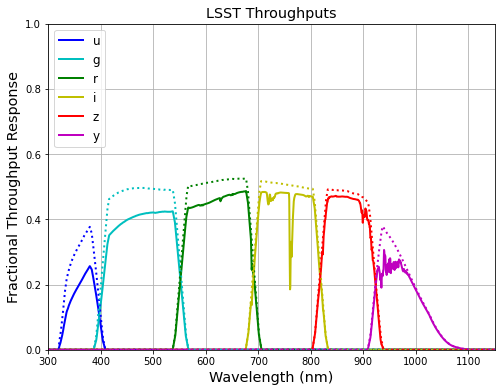

In [12]:
# Plot throughputs, together with required Sb (integrated hardware) and Tb (integrated system) values
# (for SRD design values)
# TODO

plt.figure(figsize=(8,6))
st.plotBandpasses(system, 'LSST Throughputs', newfig=False, addlegend=True)
plt.legend(loc='upper left', fancybox=True, fontsize='large')
st.plotBandpasses(hardware, newfig=False, linestyle=':', addlegend=False)

In [13]:
# Calculate dark sky, X=1.0, srd_fiducial seeing m5 and Cm values 
# "throughputs" == throughput components, X=1.0, dark sky sed, 
#  and srd_fiducial seeing (corresponds to 0.62" 500nm zenith seeing)

k = 'throughputs'
m5[k] = {}
Cm[k] = {}

for f in filterlist:
    m5[k][f] = photUtils.calcM5(darksky, system[f], hardware[f],
                                photParams[f], FWHMeff=fid_fwhmEff[f])
    
    Cm[k][f] = m5_to_Cm(m5[k][f], skyMag[f], fid_fwhmEff[f], kAtm[f], X=1.0)

    
keys = ['srd', 'throughputs']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900000,25.000000,24.700000,24.000000,23.300000,22.100000
m5 throughputs,24.073901,24.821949,24.359139,23.934198,23.363197,22.468393
Cm srd,23.043482,24.410562,24.600000,24.217442,23.924538,23.170606
Cm throughputs,23.390261,24.429123,24.445795,24.340469,24.180899,23.752479


In [14]:
# The throughputs result in 'passing' Cm but below-design m5. This is primarily due to the change in seeing.
# So add another version with SRD-level seeing. 

k = 'throughputs srd_seeing'
m5[k] = {}
Cm[k] = {}

for f in filterlist:
    m5[k][f] = photUtils.calcM5(darksky, system[f], hardware[f],
                                photParams[f], FWHMeff=seeing_srd[f])
    
    Cm[k][f] = m5_to_Cm(m5[k][f], skyMag[f], seeing_srd[f], kAtm[f], X=1.0)

    
keys = ['srd', 'throughputs', 'throughputs srd_seeing']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900000,25.000000,24.700000,24.000000,23.300000,22.100000
m5 throughputs,24.073901,24.821949,24.359139,23.934198,23.363197,22.468393
m5 throughputs srd_seeing,24.261189,25.009117,24.541512,24.124342,23.559053,22.670130
Cm srd,23.043482,24.410562,24.600000,24.217442,23.924538,23.170606
Cm throughputs,23.390261,24.429123,24.445795,24.340469,24.180899,23.752479
Cm throughputs srd_seeing,23.384306,24.425800,24.443217,24.338074,24.178802,23.750533


We have an updated seeing model, based on an updated 'raw seeing' (FWHM_500) distribution.
The new model is based on a longer time baseline of seeing values (this is the primary difference to the source of the 'fiducial' value above). 

In [15]:
# Our current best simulation of the seeing is documented in https://rtn-022.lsst.io/v/u-neilsen-draft0/index.html
# The expected seeing is that the median fwhm_500 = 0.7"

seeing_db_file = os.path.join(get_data_dir(), 'site_models', "simsee_pachon_58777_16.db")
conn = sqlite3.connect(seeing_db_file)
seeing_data = pd.read_sql('select seeing from Seeing', conn)

Text(0.4, 0.5, 'Median FWHM 500nm 0.70')

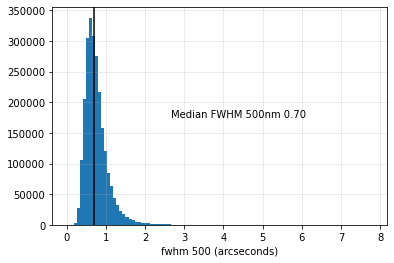

In [16]:
n,b,p = plt.hist(seeing_data['seeing'], bins=100)
plt.xlabel('fwhm 500 (arcseconds)')
plt.grid(alpha=0.3)
med_fwhm_500 = np.median(seeing_data['seeing'])
plt.axvline(med_fwhm_500, color='k')
plt.figtext(0.4, 0.5, s=f'Median FWHM 500nm {med_fwhm_500:.2f}')

In [17]:
# Calculate the corresponding X=1.0 delivered seeing per band
db_fwhmEff = dict(zip(filterlist, seeing_model(med_fwhm_500, 1.0)['fwhmEff']))

pd.DataFrame([seeing_srd, fid_fwhmEff, db_fwhmEff], 
             index=['SRD', 'fiducial', 'database median'])

,u,g,r,i,z,y
SRD,0.770000,0.730000,0.700000,0.670000,0.650000,0.630000
fiducial,0.920000,0.870000,0.830000,0.800000,0.780000,0.760000
database median,1.019193,0.957095,0.902355,0.865599,0.839998,0.820451


In [18]:
# And then the m5 and Cm values, using the database median value of seeing, at dark sky, X=1.0
k = 'seeing X=1'
m5[k] = {}
Cm[k] = {}

for f in filterlist:
    m5[k][f] = photUtils.calcM5(darksky, system[f], hardware[f],
                                             photParams[f], FWHMeff=db_fwhmEff[f])
    
    Cm[k][f] = m5_to_Cm(m5[k][f], skyMag[f], db_fwhmEff[f], kAtm[f], X=1.0)

    
keys = ['srd', 'throughputs', 'seeing X=1']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900000,25.000000,24.700000,24.000000,23.300000,22.100000
m5 throughputs,24.073901,24.821949,24.359139,23.934198,23.363197,22.468393
m5 seeing X=1,23.965705,24.719937,24.269504,23.849567,23.283487,22.385990
Cm srd,23.043482,24.410562,24.600000,24.217442,23.924538,23.170606
Cm throughputs,23.390261,24.429123,24.445795,24.340469,24.180899,23.752479
Cm seeing X=1,23.393236,24.430700,24.446908,24.341404,24.181648,23.753174


And add an update to the sky brightness model, coming from rubin_sim.skybrightness. The primary difference here is that the new model is capable of generating sky brightness over a range of conditions, instead of a single dark-sky SED as above. The dark sky skybrightness values between the two are similar, although not exactly the same. The new model is validated against photometry measurements both from the site and nearby; the single SED is a composite documented in LSE-40 (referenced above). 

The new sky model is somewhat brighter in 'u' band, however, 'u' is still read-noise limited so this isn't a significant impact.

In [19]:
# Our skybrightness model, even at dark sky, advances beyond the dark sky sed
# Note that this difference is primarily due to the fact that the skybrightness model is fitting observed
# sky values from the site and near the site -- instead of fitting an expected SED to older skybrightness
# values from a different site
# These are still zenith (X~1) values
# values pulled from https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/science/teff_fiducial.ipynb
dark_sky = {'u': 22.68,
           'g': 22.11,
           'r': 21.11,
           'i': 20.39,
           'z': 19.43,
           'y': 18.63}

pd.DataFrame([skymag_srd, skyMag, dark_sky], index=['SRD sky mag', 'SED sky mag', 'Model sky mag'])

,u,g,r,i,z,y
SRD sky mag,22.92000,22.270000,21.20000,20.470000,19.590000,18.630000
SED sky mag,22.96073,22.257758,21.19659,20.477419,19.599578,18.610405
Model sky mag,22.68000,22.110000,21.11000,20.390000,19.430000,18.630000


In [20]:
# Add the dark sky model instead of the dark sky SED calculated dark sky

k = 'seeing+sky X=1'
m5[k] = {}
Cm[k] = {}


for f in filterlist:
    # Assume the dark sky sed is good to use for the shape of the sky, but rescale to have the expected
    # dark_sky value magnitude
    darksky_copy = photUtils.Sed()
    darksky_copy.setSED(wavelen = darksky.wavelen, flambda = darksky.flambda)
    fluxNorm = darksky_copy.calcFluxNorm(dark_sky[f], hardware[f])
    darksky_copy.multiplyFluxNorm(fluxNorm)
    m5[k][f] = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                             photParams[f], FWHMeff=db_fwhmEff[f])
    Cm[k][f] = m5_to_Cm(m5[k][f], dark_sky[f], db_fwhmEff[f], kAtm[f], X=1.0)

    
keys = ['srd', 'throughputs', 'seeing X=1', 'seeing+sky X=1']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900000,25.000000,24.700000,24.000000,23.300000,22.100000
m5 throughputs,24.073901,24.821949,24.359139,23.934198,23.363197,22.468393
m5 seeing X=1,23.965705,24.719937,24.269504,23.849567,23.283487,22.385990
m5 seeing+sky X=1,23.893913,24.666608,24.233507,23.811343,23.205911,22.395085
Cm srd,23.043482,24.410562,24.600000,24.217442,23.924538,23.170606
Cm throughputs,23.390261,24.429123,24.445795,24.340469,24.180899,23.752479
Cm seeing X=1,23.393236,24.430700,24.446908,24.341404,24.181648,23.753174
Cm seeing+sky X=1,23.461809,24.451250,24.454206,24.346890,24.188861,23.752472


(note: the Cm value for u band changes above when the new sky values are introduced; in general it should not, but it does here because u band is readnoise limited, not sky-noise limited. As a result, Cm can change because it includes underlying assumptions that the m5 limit is due to sky-noise only. In use, this is compensated for with an additional term, 'dCm'). 

## Add simulations of survey cadence ##

First, we note that the code used to calculate the m5 depths in the simulations is slightly different than the calculation above; for both speed and to be able to calculate m5 depths in all ranges of airmass, seeing, and sky brightness, we use the Cm equation reference above to calculate m5. Thus it's important to note the values of Cm being used to calculate m5 depths coming from the opsim outputs, and to verify that they match the Cm values that would be generated by our current throughputs.

In [21]:
# What values for Cm are used in the cadence simulations?
# These are calculated based on 30s visits and X=1.2 -- see below 
# (SysEngVals is the piece of code we store the refence numbers, but is calculated as in next cell)

vals = rsUtils.SysEngVals()
Cm_cadence_reference = vals.Cm

# The reference values can be recreated as follows:
Cm_cadence_calc = {}
for f in filterlist:
    m5_tmp = photUtils.calcM5(darksky, system[f], hardware[f],
                                photParameters_30, FWHMeff=fid_fwhmEff[f])
    
    Cm_cadence_calc[f] = m5_to_Cm(m5_tmp, skyMag[f], fid_fwhmEff[f], kAtm[f], X=1.0)

pd.DataFrame([Cm_cadence_reference, Cm_cadence_calc], 
             index=['Cm cadence reference', 'Cm cadence calculated'])

,u,g,r,i,z,y
Cm cadence reference,23.390261,24.506791,24.489914,24.372551,24.202753,23.769195
Cm cadence calculated,23.390261,24.506791,24.489914,24.372551,24.202753,23.769195


In [22]:
# The Cm cadence values above are used for simulations, but are scaled appropriately for the given exposure time 
# and conditions. The scaling can introduce errors up to but typically less than 0.01 magnitudes.
# We use rubin_sim.utils.m5_flat_sed for this scaling.

k = 'cadence reference'
m5[k] = {}
Cm[k] = Cm_cadence_reference

for f in filterlist:
    if f == 'u':
        expTime = 30
        nexp = 1
    else:
        expTime = 15
        nexp = 2
    m5[k][f] = rsUtils.m5_flat_sed(f, dark_sky[f], db_fwhmEff[f], expTime=expTime, airmass=1.0, nexp=nexp)
    
keys = ['srd', 'throughputs', 'seeing X=1', 'seeing+sky X=1', 'cadence reference']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900000,25.000000,24.700000,24.000000,23.300000,22.100000
m5 throughputs,24.073901,24.821949,24.359139,23.934198,23.363197,22.468393
m5 seeing X=1,23.965705,24.719937,24.269504,23.849567,23.283487,22.385990
m5 seeing+sky X=1,23.893913,24.666608,24.233507,23.811343,23.205911,22.395085
m5 cadence reference,23.887463,24.658823,24.228803,23.807699,23.202983,22.393172
Cm srd,23.043482,24.410562,24.600000,24.217442,23.924538,23.170606
Cm throughputs,23.390261,24.429123,24.445795,24.340469,24.180899,23.752479
Cm seeing X=1,23.393236,24.430700,24.446908,24.341404,24.181648,23.753174
Cm seeing+sky X=1,23.461809,24.451250,24.454206,24.346890,24.188861,23.752472
Cm cadence reference,23.390261,24.506791,24.489914,24.372551,24.202753,23.769195


The Cm values in the simulation ('vals') are appropriate for use in the scaling function, and match what is expected from the system throughputs, as calculated above ('Cm cadence reference'). The m5 values above are calculated for the appropriate exposure time and number of exposures per visit, consistent with the 'seeing+sky, X=1' line.

### Evaluating m5 depths in cadence outputs. ###

In practice, the LSST observations will cover a range of airmasses, skybrightness, and seeing values, which will all impact the five sigma point source magnitude limit (m5). The conditions above are for dark sky and zenith (X=1) conditions; all real-world observations will result in m5 values which are shallower, as airmass and sky brightness can only increase. The seeing above is a median, so sometimes we will acquire images with better seeing and thus potentially fainter m5 values. These ranges can be influenced by survey strategy, but only up to an given extent as we will use all available time (and thus have to accept a range of sky brightness and seeing). 

In addition, the final coadded depth is dependent on the number of visits acquired at any point in the sky, which is strongly dependent on survey strategy, although again has limitations around the total survey lifetime, minimum survey area, and observing duty-cycle requirements. 

In [23]:
# In an implemented survey, such as baseline_v2.0_10yrs -- 
# we have a range of airmasses, seeing, and skybrightness values

# Pull up median values of each of these

opsim_db_file = get_baseline()
runName = os.path.split(opsim_db_file)[-1].replace('.db', '')
print(runName)

baseline_v2.0_10yrs


In [24]:
colmap = maf.ColMapDict()
colmap['skyBrightness'], colmap['seeingEff'], colmap['fiveSigmaDepth']

('skyBrightness', 'seeingFwhmEff', 'fiveSigmaDepth')

In [25]:
b = {}
b['median airmass'] = maf.MetricBundle(maf.MedianMetric('airmass'),
                                      maf.UniSlicer(), None)
b['airmass histogram'] = maf.MetricBundle(maf.CountMetric('airmass'),
                                         maf.OneDSlicer('airmass'), None)
b['median fwhm_500'] = maf.MetricBundle(maf.MedianMetric('seeingFwhm500'), maf.UniSlicer(), None)
b['fwhm_500 histogram'] = maf.MetricBundle(maf.CountMetric('seeingFwhm500'),
                                                maf.OneDSlicer('seeingFwhm500'), None)

filtercolors = {"u": "cyan", "g": "g", "r": "orange", "i": "r", "z": "m", "y": "b"}
for f in filterlist:
    sql = f'filter == "{f}"'
    plotDict = {'color': filtercolors[f]}
    b[f'median skybrightness {f}'] = maf.MetricBundle(maf.MedianMetric('skyBrightness'), maf.UniSlicer(), sql)
    b[f'skybrightness histogram {f}'] = maf.MetricBundle(maf.CountMetric('skyBrightness'),
                                                        maf.OneDSlicer('skyBrightness'), sql)
    b[f'median seeingFwhmEff {f}'] = maf.MetricBundle(maf.MedianMetric('seeingFwhmEff'), maf.UniSlicer(), sql)
    b[f'seeingFwhmEff histogram {f}'] = maf.MetricBundle(maf.CountMetric('seeingFwhmEff'),
                                                    maf.OneDSlicer('seeingFwhmEff'), sql)
    b[f'median m5 {f}'] = maf.MetricBundle(maf.MedianMetric('fiveSigmaDepth'), maf.UniSlicer(), sql)
    b[f'm5 histogram {f}'] = maf.MetricBundle(maf.CountMetric('fiveSigmaDepth'),
                                                maf.OneDSlicer('fiveSigmaDepth'), sql)
    b[f'median visit m5 {f}'] = maf.MetricBundle(maf.MedianMetric('fiveSigmaDepth'),
                                                maf.HealpixSlicer(nside=64), sql,
                                                summaryMetrics=[maf.MedianMetric()])
    b[f'coadd m5 {f}'] = maf.MetricBundle(maf.Coaddm5Metric(), maf.HealpixSlicer(nside=64), sql,
                                         summaryMetrics=[maf.MedianMetric()])
    b[f'Nvisits {f}'] = maf.MetricBundle(maf.CountMetric('observationStartMJD'),
                                            maf.HealpixSlicer(nside=64), sql,
                                            summaryMetrics=[maf.MedianMetric()])
for k in b:
    b[k].setRunName(runName)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [26]:
g = maf.MetricBundleGroup(b, opsim_db_file, 'm5_metrics', None, dbTable='observations')
g.runAll()

Querying database observations with no constraint for columns ['seeingFwhm500', 'airmass'].
Found 2086980 visits
Running:  ['median airmass', 'median fwhm_500']
Completed metric generation.
Running:  ['airmass histogram']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 569 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['fwhm_500 histogram']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 1490 bins, returning 200
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter == "u" for columns ['skyBrightness', 'fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'observationStartMJD', 'seeingFwhmEff', 'fieldRA']
Found 134566 visits
Running:  ['median skybrightness u', 'median seeingFwhmEff u', 'median m5 u']
Completed metric generation.
Running:  ['skybrightness histogram u']
Completed metric generation.
Running:  ['seeingFwhmEff histogram u']
Completed metric generation.
Running:  ['m5 histogram u']
Completed metric generation.
Running:  ['median visit m5 u', 'coadd m5 u', 'Nvisits u']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 230 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 352 bins, returning 200
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter == "i" for columns ['skyBrightness', 'fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'observationStartMJD', 'seeingFwhmEff', 'fieldRA']
Found 473684 visits
Running:  ['median skybrightness i', 'median seeingFwhmEff i', 'median m5 i']
Completed metric generation.
Running:  ['skybrightness histogram i']
Completed metric generation.
Running:  ['seeingFwhmEff histogram i']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 531 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 223 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram i']
Completed metric generation.
Running:  ['median visit m5 i', 'coadd m5 i', 'Nvisits i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter == "g" for columns ['skyBrightness', 'fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'observationStartMJD', 'seeingFwhmEff', 'fieldRA']
Found 217817 visits
Running:  ['median skybrightness g', 'median seeingFwhmEff g', 'median m5 g']
Completed metric generation.
Running:  ['skybrightness histogram g']
Completed metric generation.
Running:  ['seeingFwhmEff histogram g']
Completed metric generation.
Running:  ['m5 histogram g']
Completed metric generation.
Running:  ['median visit m5 g', 'coadd m5 g', 'Nvisits g']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 654 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 444 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 225 bins, returning 200
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter == "z" for columns ['skyBrightness', 'fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'observationStartMJD', 'seeingFwhmEff', 'fieldRA']
Found 404430 visits
Running:  ['median skybrightness z', 'median seeingFwhmEff z', 'median m5 z']
Completed metric generation.
Running:  ['skybrightness histogram z']
Completed metric generation.
Running:  ['seeingFwhmEff histogram z']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 572 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 250 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram z']
Completed metric generation.
Running:  ['median visit m5 z', 'coadd m5 z', 'Nvisits z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter == "r" for columns ['skyBrightness', 'fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'observationStartMJD', 'seeingFwhmEff', 'fieldRA']
Found 464851 visits
Running:  ['median skybrightness r', 'median seeingFwhmEff r', 'median m5 r']
Completed metric generation.
Running:  ['skybrightness histogram r']
Completed metric generation.
Running:  ['seeingFwhmEff histogram r']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 592 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 487 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram r']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 285 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['median visit m5 r', 'coadd m5 r', 'Nvisits r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter == "y" for columns ['skyBrightness', 'fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'observationStartMJD', 'seeingFwhmEff', 'fieldRA']
Found 391632 visits
Running:  ['median skybrightness y', 'median seeingFwhmEff y', 'median m5 y']
Completed metric generation.
Running:  ['skybrightness histogram y']
Completed metric generation.
Running:  ['seeingFwhmEff histogram y']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 847 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 256 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram y']
Completed metric generation.
Running:  ['median visit m5 y', 'coadd m5 y', 'Nvisits y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


#### Airmass #### 
The median airmass is about X=1.2, which is consistent with previous assumptions for calculating 'typical' m5 depths in work like the Overview Paper. Increasing the airmass decreases the m5 value by kAtm*(X-1), but increasing the airmass also changes the delivered seeing and skybrightness values, so has a larger effect on the resulting change in m5. Note that this will not change Cm at all, as Cm is independent of observing conditions.

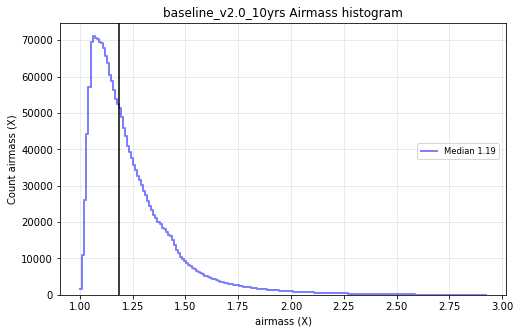

In [46]:
# Visualize the range of airmasses 
ph = maf.PlotHandler(outDir='m5_metrics', thumbnail=False, figformat='pdf')
ph.setMetricBundles([b['airmass histogram']])
plotDict = {'figsize': (8, 5), 
            'title': f'{runName} Airmass histogram', 
            'yMin': 0,
            'linewidth': 2,
           'label': f"Median {b['median airmass'].metricValues[0]:.2f}",
           'legendloc': (0.8, 0.5)}
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotDict)
plt.axvline(b['median airmass'].metricValues[0], color='k')

#### Seeing ####
The median atmospheric contribution to the seeing (FWHM_500) is 0.72", which is close to but not quite the same as the 'median db_seeing' evaluated above. Differences can arise due to when observations are acquired, thus skipping some of the database values (due to downtime or other telescope closures, as the database above is a continuously running model estimate used to generate fwhm_500 at the precise times of observations). 

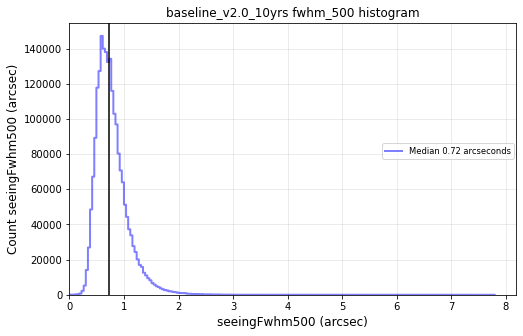

In [47]:
# Visualize the range of atmospheric seeing -- this should be close to the 'db_seeing' above, but may 
# slightly differ due to including or not including some of the database values (due to daytime, downtime, etc)
ph.setMetricBundles([b['fwhm_500 histogram']])
plotDict = {'figsize': (8, 5), 
            'title': f'{runName} fwhm_500 histogram', 
            'yMin': 0, 'xMin': 0,
            'linewidth': 2,
           'label': f"Median {b['median fwhm_500'].metricValues[0]:.2f} arcseconds",
           'legendloc': (0.7, 0.5),
           'fontsize': 'large'}
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotDict)
plt.axvline(b['median fwhm_500'].metricValues[0], color='k')

The delivered seeing depends on the bandpass, as well as the airmass, in which a visit is acquired. It includes the telescope and dome contributions to the atmospheric seeing.

1

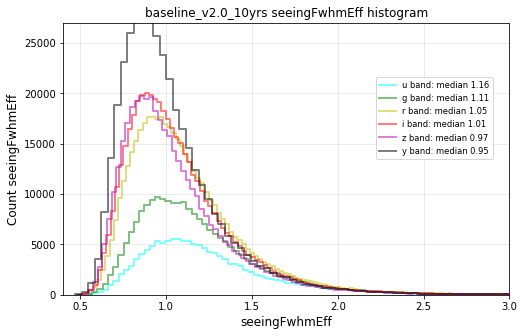

In [48]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'seeingFwhmEff histogram {f}'])
    key = f'median seeingFwhmEff {f}'
    plotList.append({'linewidth': 2, 
                     'legendloc': (0.7, 0.5), 
                     'figsize': (8, 5),
                     'title': f'{runName} seeingFwhmEff histogram', 
                    'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':27000, 
            'xMin': 0.4, 'xMax': 3,
           'fontsize': 'large'}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

In [49]:
# We can compare these per-band median seeing values from the simulation
# with the expected seeing per-band from the median fwhm500 at X=1.2
# We see they are pretty close, so we're distributing visits in seeing and airmass fairly well between filters
predicted_median = seeing_model(b['median fwhm_500'].metricValues[0], 1.2)['fwhmEff']
simulated_median_seeing = []
for f in filterlist:
    simulated_median_seeing.append(b[f'median seeingFwhmEff {f}'].metricValues[0])

pd.DataFrame([predicted_median, simulated_median_seeing], 
             index=['Predicted median fwhmEff', 'Simulated median fwhmEff'],
             columns=filterlist)

,u,g,r,i,z,y
Predicted median fwhmEff,1.164406,1.092577,1.029207,0.986623,0.956945,0.934275
Simulated median fwhmEff,1.159288,1.108141,1.045683,1.005841,0.974557,0.953590


#### Skybrightness ####
Along with airmass and seeing, the actual range of skybrightness is also important for single visit m5 depth. 

1

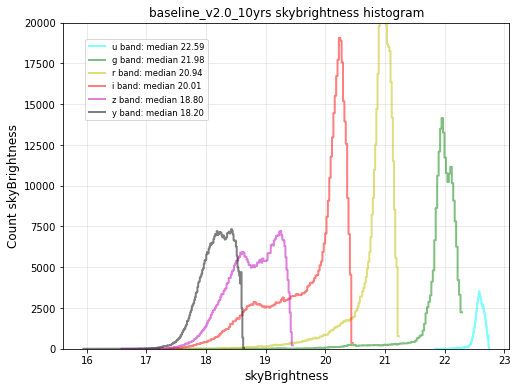

In [50]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'skybrightness histogram {f}'])
    key = f'median skybrightness {f}'
    plotList.append({'figsize': (8, 6), 'fontsize': 'large',
                     'linewidth': 2, 'legendloc': (0.05, 0.7),
                     'title': f'{runName} skybrightness histogram', 
                     'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':20000}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

In [51]:
# and of course these per-band skybrightness values cover a wider range than the dark-sky values
simulated_median_skybrightness = {}
for f in filterlist:
    simulated_median_skybrightness[f] = b[f'median skybrightness {f}'].metricValues[0]

pd.DataFrame([dark_sky, simulated_median_skybrightness], 
             index=['Dark sky skybrightness', 'Simulated median skybrightness'],
             columns=filterlist)

,u,g,r,i,z,y
Dark sky skybrightness,22.680000,22.110000,21.110000,20.390000,19.4300,18.630000
Simulated median skybrightness,22.590904,21.976759,20.935947,20.014484,18.8037,18.196812


Choosing filters appropriately for the lunar phase helps keeps these skybrightness values closer to the 'dark sky' values, but the redder filters still experience some increase in background skybrightness. The redder filters are used primarily during bright times and twilight; it is to be expected that the sky brightness is higher.

Using the same scaling relationship we use in the cadence simulation, we can evaluate the impact of each of these contributions 'separately' (even though they are not entirely independent in reality). 
Compare against 'seeing+sky X=1' -- seeing == database median fwhmEff per band, airmass = 1, sky = skybrightness model dark sky

In [52]:
sim_m5 = {}
keys = ['seeing+sky X=1', 'airmass X=1.2', 'seeing ~1.0', 'skybrightness median', 'medians combo']
for k in keys:
    sim_m5[k] = {}
    
expTime = {}
nexp = {}
for f in filterlist:
    expTime[f] = 15
    nexp[f] = 2
expTime['u'] = 30
nexp['u'] = 1

for f in filterlist:
    sim_m5['seeing+sky X=1'][f] = m5['seeing+sky X=1'][f]
    sim_m5['skybrightness median'][f] = rsUtils.m5_flat_sed(f, 
                                                  simulated_median_skybrightness[f],
                                                  db_fwhmEff[f],
                                                 expTime[f], airmass=1, nexp=nexp[f])
    sim_m5['airmass X=1.2'][f] = rsUtils.m5_flat_sed(f, 
                                           dark_sky[f],
                                           db_fwhmEff[f], 
                                           expTime[f], 
                                           airmass=b['median airmass'].metricValues[0],
                                            nexp=nexp[f])
    sim_m5['seeing ~1.0'][f] = rsUtils.m5_flat_sed(f,
                                          dark_sky[f],
                                          b[f'median seeingFwhmEff {f}'].metricValues[0],
                                          expTime[f],
                                          airmass=1.0,
                                          nexp=nexp[f])
    sim_m5['medians combo'][f] = rsUtils.m5_flat_sed(f,
                                          simulated_median_skybrightness[f],
                                          b[f'median seeingFwhmEff {f}'].metricValues[0],
                                          expTime[f],
                                          airmass=b['median airmass'].metricValues[0],
                                          nexp=nexp[f])
d = pd.DataFrame(sim_m5)
# Show decrease in magnitude limit due to each component and total
d.subtract(d['seeing+sky X=1'], axis=0)*-1

,seeing+sky X=1,airmass X=1.2,seeing ~1.0,skybrightness median,medians combo
u,-0.0,0.099784,0.146288,0.032211,0.265382
g,-0.0,0.047500,0.166886,0.057998,0.256814
r,-0.0,0.028096,0.164761,0.079002,0.262450
i,-0.0,0.021516,0.166677,0.172880,0.353784
z,-0.0,0.015679,0.164250,0.298318,0.472391
y,-0.0,0.033410,0.165185,0.206534,0.401302


We can compare these against the individual visit m5 in the simulations, to check on these 'typical' median values. 

1

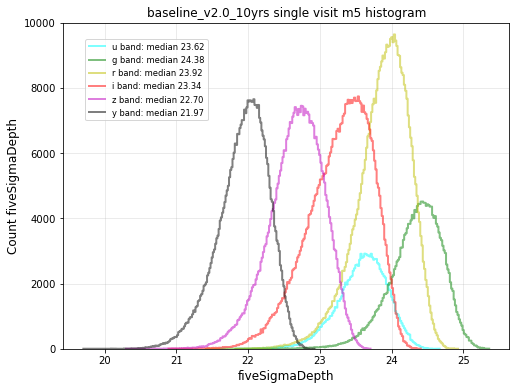

In [53]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'm5 histogram {f}'])
    key = f'median m5 {f}'
    plotList.append({'figsize': (8, 6), 'fontsize': 'large',
                     'linewidth': 2, 'legendloc': (0.05, 0.7),
                     'title': f'{runName} single visit m5 histogram', 
                     'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':10000}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

In [54]:
sim_m5['simulation'] = {}
for f in filterlist:
    sim_m5['simulation'][f] = b[f"median m5 {f}"].metricValues[0]
pd.DataFrame(sim_m5)

,seeing+sky X=1,airmass X=1.2,seeing ~1.0,skybrightness median,medians combo,simulation
u,23.893913,23.794129,23.747625,23.861702,23.628532,23.621676
g,24.666608,24.619108,24.499722,24.608610,24.409794,24.381156
r,24.233507,24.205411,24.068746,24.154506,23.971057,23.923410
i,23.811343,23.789827,23.644667,23.638464,23.457559,23.340875
z,23.205911,23.190232,23.041661,22.907593,22.733519,22.702109
y,22.395085,22.361675,22.229900,22.188552,21.993784,21.971586


The "typical" values of airmass, seeing, and skybrightness result in changes in the single visit limiting magnitude which correspond well to the median individual visit depths from the simulation. We can then trace the changes in limiting magnitude according to conditions; note that Cm has been constant throughout all of the simulation evaluation.

In [55]:
d = pd.DataFrame(m5).join(pd.DataFrame(sim_m5).drop('seeing+sky X=1', axis=1))
c = pd.DataFrame(Cm)

In [56]:
c.add_prefix('Cm ')  # Note that u band Cm values are problematic due to read-noise interference

,Cm srd,Cm throughputs,Cm throughputs srd_seeing,Cm seeing X=1,Cm seeing+sky X=1,Cm cadence reference
u,23.043482,23.390261,23.384306,23.393236,23.461809,23.390261
g,24.410562,24.429123,24.425800,24.430700,24.451250,24.506791
r,24.600000,24.445795,24.443217,24.446908,24.454206,24.489914
i,24.217442,24.340469,24.338074,24.341404,24.346890,24.372551
z,23.924538,24.180899,24.178802,24.181648,24.188861,24.202753
y,23.170606,23.752479,23.750533,23.753174,23.752472,23.769195


In [60]:
c.subtract(c['srd'], axis=0).add_prefix('Cm ')

,Cm srd,Cm throughputs,Cm throughputs srd_seeing,Cm seeing X=1,Cm seeing+sky X=1,Cm cadence reference
u,0.0,0.346779,0.340824,0.349754,0.418327,0.346779
g,0.0,0.018561,0.015238,0.020138,0.040688,0.096229
r,0.0,-0.154205,-0.156783,-0.153092,-0.145794,-0.110086
i,0.0,0.123027,0.120633,0.123962,0.129448,0.155109
z,0.0,0.256361,0.254264,0.257110,0.264323,0.278215
y,0.0,0.581873,0.579927,0.582568,0.581866,0.598589


In [61]:
d.add_prefix('m5 ')

,m5 srd,m5 throughputs,m5 throughputs srd_seeing,m5 seeing X=1,m5 seeing+sky X=1,m5 cadence reference,m5 airmass X=1.2,m5 seeing ~1.0,m5 skybrightness median,m5 medians combo,m5 simulation
u,23.9,24.073901,24.261189,23.965705,23.893913,23.887463,23.794129,23.747625,23.861702,23.628532,23.621676
g,25.0,24.821949,25.009117,24.719937,24.666608,24.658823,24.619108,24.499722,24.608610,24.409794,24.381156
r,24.7,24.359139,24.541512,24.269504,24.233507,24.228803,24.205411,24.068746,24.154506,23.971057,23.923410
i,24.0,23.934198,24.124342,23.849567,23.811343,23.807699,23.789827,23.644667,23.638464,23.457559,23.340875
z,23.3,23.363197,23.559053,23.283487,23.205911,23.202983,23.190232,23.041661,22.907593,22.733519,22.702109
y,22.1,22.468393,22.670130,22.385990,22.395085,22.393172,22.361675,22.229900,22.188552,21.993784,21.971586


In [62]:
d.subtract(d['srd'], axis=0).add_prefix('m5 ')

,m5 srd,m5 throughputs,m5 throughputs srd_seeing,m5 seeing X=1,m5 seeing+sky X=1,m5 cadence reference,m5 airmass X=1.2,m5 seeing ~1.0,m5 skybrightness median,m5 medians combo,m5 simulation
u,0.0,0.173901,0.361189,0.065705,-0.006087,-0.012537,-0.105871,-0.152375,-0.038298,-0.271468,-0.278324
g,0.0,-0.178051,0.009117,-0.280063,-0.333392,-0.341177,-0.380892,-0.500278,-0.391390,-0.590206,-0.618844
r,0.0,-0.340861,-0.158488,-0.430496,-0.466493,-0.471197,-0.494589,-0.631254,-0.545494,-0.728943,-0.776590
i,0.0,-0.065802,0.124342,-0.150433,-0.188657,-0.192301,-0.210173,-0.355333,-0.361536,-0.542441,-0.659125
z,0.0,0.063197,0.259053,-0.016513,-0.094089,-0.097017,-0.109768,-0.258339,-0.392407,-0.566481,-0.597891
y,0.0,0.368393,0.570130,0.285990,0.295085,0.293172,0.261675,0.129900,0.088552,-0.106216,-0.128414


In [65]:
d.subtract(d['seeing+sky X=1'], axis=0).add_prefix('m5 ')

,m5 srd,m5 throughputs,m5 throughputs srd_seeing,m5 seeing X=1,m5 seeing+sky X=1,m5 cadence reference,m5 airmass X=1.2,m5 seeing ~1.0,m5 skybrightness median,m5 medians combo,m5 simulation
u,0.006087,0.179988,0.367276,0.071792,0.0,-0.006450,-0.099784,-0.146288,-0.032211,-0.265382,-0.272237
g,0.333392,0.155341,0.342509,0.053329,0.0,-0.007785,-0.047500,-0.166886,-0.057998,-0.256814,-0.285452
r,0.466493,0.125632,0.308005,0.035997,0.0,-0.004705,-0.028096,-0.164761,-0.079002,-0.262450,-0.310097
i,0.188657,0.122855,0.312999,0.038224,0.0,-0.003644,-0.021516,-0.166677,-0.172880,-0.353784,-0.470469
z,0.094089,0.157286,0.353142,0.077576,0.0,-0.002928,-0.015679,-0.164250,-0.298318,-0.472391,-0.503802
y,-0.295085,0.073308,0.275044,-0.009096,0.0,-0.001914,-0.033410,-0.165185,-0.206534,-0.401302,-0.423499


The biggest drop is in r band -- which does fall compared to SRD design values with our current throughputs (it also shows up in the Cm values). 

All bandpasses meet SRD minimum requirements for Cm. 
All bandpasses other than r band meet SRD design requirements for Cm.

In [63]:
Cm_min  = {}

for f in filterlist:
    Cm_min[f] = m5_to_Cm(m5_min[f], skymag_srd[f], seeing_srd[f], kAtm_srd[f], X=1.0)
pd.DataFrame([Cm_min, Cm['srd'], Cm_cadence_reference], 
             index=['Cm minimum requirement', 'Cm SRD design', 'Cm seeing+sky X=1'])

,u,g,r,i,z,y
Cm minimum requirement,22.543482,24.010562,24.200000,23.817442,23.524538,22.770606
Cm SRD design,23.043482,24.410562,24.600000,24.217442,23.924538,23.170606
Cm seeing+sky X=1,23.390261,24.506791,24.489914,24.372551,24.202753,23.769195


The final m5 values do fall below SRD m5 single visit expectations, but this is due to 
* evolving understanding of the atmospheric delivered seeing (FWHM_500 was 0.43" for the SRD, became 0.62" for the fiducial values, and is now 0.72" median value over 10 years for the simulation inputs). This is visible even before adding a range of observing conditions, in the `seeing X=1` values, as well. This has an impact of about 0.16 magnitudes. The final atmospheric contribution to seeing will be determined by weather.
* observing in a range of skybrightness conditions. This has an impact of between 0.3 to 0.03 magnitudes, depending on bandpass. The redder bands suffer larger losses, but also have higher throughputs compared to the SRD. This is generally unavoidable, as dark time must be used for the bluer bandpasses where sky brightness variations are larger.
* observing at a range of airmasses, with a median of X=1.2. This has an impact of between 0.1 to 0.01 magnitudes, depending on bandpass.  This is a minimal impact for the overall gain of survey flexibility, longer seasonal availability, and better parallax determination. Note that future survey choices may make larger impacts here, if observations are driven to higher airmass.
* in the r band, choices related to balancing red and blue throughput and the mirror coatings result in slightly lower throughput overall. (this should be run past Chuck for validation .. but I believe the choice of Al instead of Ag for the mirror coatings were where the r band throughput dropped to its current level). 

In [66]:
# Zeljko - I will go back to the 'seeing+sky X=1' set of throughputs, skybrightness,
# and seeing values, and run the per-amp analysis. (most likely in a separate notebook).